# 資料定義

In [1]:
import pandas as pd
import pyodbc
import numpy as np

class get_df:

    def __init__(self):
        self.DB_infos = {"X01" : ("192.168.1.16", "X01", "cm23357868", "86875332")}
        self.querys = {}
        self.db = str()
        self.df_dict =  dict()
        self.w_code_dict = dict()
        self.point_dict = dict()
        self.result_dict = dict()
        
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        return df
    @staticmethod
    def make_ETF():
        sql_ETF_price ="""SELECT    [日期]
                        ,[股票代號]
                        ,[股票名稱]
                        ,[開盤價]
                        ,[最高價]
                        ,[最低價]
                        ,[收盤價]
                        ,[漲跌]
                        ,[漲幅(%)]
                        ,[振幅(%)]
                        ,[成交量]
                        ,[成交筆數]
                        ,[成交金額(千)]
                        ,[均張]
                        ,[成交量變動(%)]
                        ,[均張變動(%)]
                        ,[股本(百萬)]
                        ,[總市值(億)]
                        ,[週轉率(%)]
                        ,[成交值比重(%)]
                        ,[漲跌停]
                        ,[成交量(股)]
                     
                    FROM [X01].[dbo].[日收盤還原表排行] where  股票代號 like '0%' and 日期 >= '20020101' order by 日期 desc"""
        return sql_ETF_price

    @staticmethod
    def make_ETF_DP():
        sql_ETF_DP ="""SELECT    [日期]
                        ,[股票代號]
                        ,[股票名稱]
                        ,[淨值]
                        ,[淨值漲跌]
                        ,[淨值漲跌幅(%)]
                        ,[折溢價(%)]
                        ,[淨值(原幣)]
                        ,[淨值漲跌(原幣)]
                        ,[淨值漲跌幅(原幣)]
                        ,[基金淨資產價值(千)]
                        ,[已發行受益權單位總數(千)]
                        ,[與前日已發行單位差異數(千)]
                        ,[已發行受益權單位總數(含加掛ETF)(千)]
                        ,[與前日已發行單位差異數(含加掛ETF)(千)]
                        ,[RTIME]
                       
                    FROM [X01].[dbo].[ETF折溢價表] where 日期 >= 20020101 order by 日期"""
        return sql_ETF_DP

# 連結SQL

In [2]:
sql_base = get_df()
sql_base.db_connect('X01')


Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


# 資料下載與轉換

In [3]:
sql_base.querys['日收盤還原表排行'] = sql_base.make_ETF()
ETFtable = sql_base.load_data('日收盤還原表排行')

sql_base.querys['ETF折溢價表'] = sql_base.make_ETF_DP()
dptable = sql_base.load_data('ETF折溢價表')

C:\Users\larryx30\AppData\Local\Temp\ipykernel_9144\383989772.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df =  pd.read_sql(self.querys[query], self.db)


In [4]:
data_frame = ETFtable.merge(dptable, on = ['日期','股票代號','股票名稱'], how = 'left').fillna(0)

In [5]:
ETF行情表 = data_frame
ETF行情表 = ETF行情表.sort_values(by = ['日期','股票代號']).reset_index(drop = True)
ETF行情表['日期'] = pd.to_datetime(ETF行情表['日期'],format = "%Y%m%d").fillna(0)
ETF行情表 = ETF行情表.set_index('日期')

In [6]:
ETF1 = pd.Series(ETF行情表['股票代號'])
ETFlist = ETF1.sort_values().drop_duplicates()
ETFlist = list(ETFlist)

In [7]:
from tqdm import tqdm
ETF_dict = {str(ETFlist[i]):ETF行情表[ETF行情表['股票代號'] == ETFlist[i]] for i in tqdm(range(len(ETFlist)))}

100%|██████████| 367/367 [00:05<00:00, 66.18it/s]


In [8]:
feature_ls = ETF行情表.columns[2:]
ETF行情表 = ETF行情表.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(ETF行情表.columns[2:]):
    data_pivot = ETF行情表.pivot(index='日期',columns='股票代號',values=feature)
    data_pivots_ls.append(data_pivot)

100%|██████████| 33/33 [00:02<00:00, 13.50it/s]


In [9]:
pivot_dict = {str(ETF行情表.columns[2:][i]):data_pivots_ls[i] for i in range(len(ETF行情表.columns[2:]))}

ETF_dict.update(pivot_dict)

In [10]:
responseETF = pd.read_excel(r'C:\Users\larryx30\Desktop\\股票型ETF代碼.xlsx')
responseETF['股票代號'] = '00'+responseETF['股票代號'].astype(str)
responseETF.index = responseETF.index+1
SETF = responseETF['股票代號']

In [11]:
ETFDDW = {}
for j in tqdm(ETFlist):
    ETFDDW[str(j)] = ETF_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last', '成交金額(千)':'sum','折溢價(%)':'mean'\
                                                           }).fillna(method = 'pad' ,axis = 0)

100%|██████████| 367/367 [00:01<00:00, 348.08it/s]


In [12]:
大盤夏普值 = pd.read_excel(r'\Users\larryx30\larryx30\每週買賣報表\大盤夏普值.xlsx')

In [13]:
大盤夏普值 = 大盤夏普值.set_index('日期')

# ETF關鍵點策略

In [14]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(SETF):
    
    ETFDDW[str(x)]['MAX52'] = ETFDDW[str(x)]["收盤價"].rolling(5).max()
    ETFDDW[str(x)]["MAX52S"] = ETFDDW[str(x)]["MAX52"].shift(1)
    ETFDDW[str(x)]["20MA"] = talib.MA(ETFDDW[str(x)]["收盤價"].dropna(), timeperiod=20, matype=0)
    ETFDDW[str(x)]["20MAS"] = ETFDDW[str(x)]["20MA"].shift(1)
    ETFDDW[str(x)]["5MA"] = talib.MA(ETFDDW[str(x)]["收盤價"].dropna(), timeperiod=5, matype=0)
    ETFDDW[str(x)]["5MAS"] = ETFDDW[str(x)]["5MA"].shift(1)
    
    ETFDDW[str(x)]["DR"] = ((ETFDDW[str(x)]["收盤價"] - ETFDDW[str(x)]["收盤價"].shift(1))/ETFDDW[str(x)]["收盤價"].shift(1))*100
    ETFDDW[str(x)]['SHARPE'] = 大盤夏普值['sharpe']
    
    KPBS = 0
    KPBUY =[]
    for z in range(len(ETFDDW[str(x)])):

        if ETFDDW[str(x)]["收盤價"].iloc[z]  > ETFDDW[str(x)]["MAX52S"].iloc[z] and ETFDDW[str(x)]['成交金額(千)'].iloc[z] > 50000 \
        and ETFDDW[str(x)]["最低價"].iloc[z] > ETFDDW[str(x)]["20MAS"].iloc[z] and ETFDDW[str(x)]['折溢價(%)'].iloc[z] < 1 and ETFDDW[str(x)]['SHARPE'].iloc[z] <1.5 :
        
            KPBS = 4

        elif (ETFDDW[str(x)]["收盤價"].iloc[z] < ETFDDW[str(x)]["最低價"].rolling(1).min().shift(1).iloc[z]  and \
         (( ETFDDW[str(x)]['收盤價'].iloc[z] < ETFDDW[str(x)]['收盤價'].rolling(20).min().shift(1).iloc[z]) ) ) :
         
            KPBS = 0
            
        KPBUY.append(KPBS)
    ETFDDW[str(x)]["KPBUY"] = KPBUY
    ETFDDW[str(x)]["KPBUYS"] = ETFDDW[str(x)]["KPBUY"].shift(1)
    pzb = ETFDDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = ETFDDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    ETFDDW[str(x)]["KPRR"] = ETFDDW[str(x)]["DR"] * ETFDDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = ETFDDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

#trrb =(trr).replace(np.inf,0).sort_index().sum(axis = 1).cumsum().plot(figsize=(20, 10),grid = True)


100%|██████████| 47/47 [00:02<00:00, 23.21it/s]


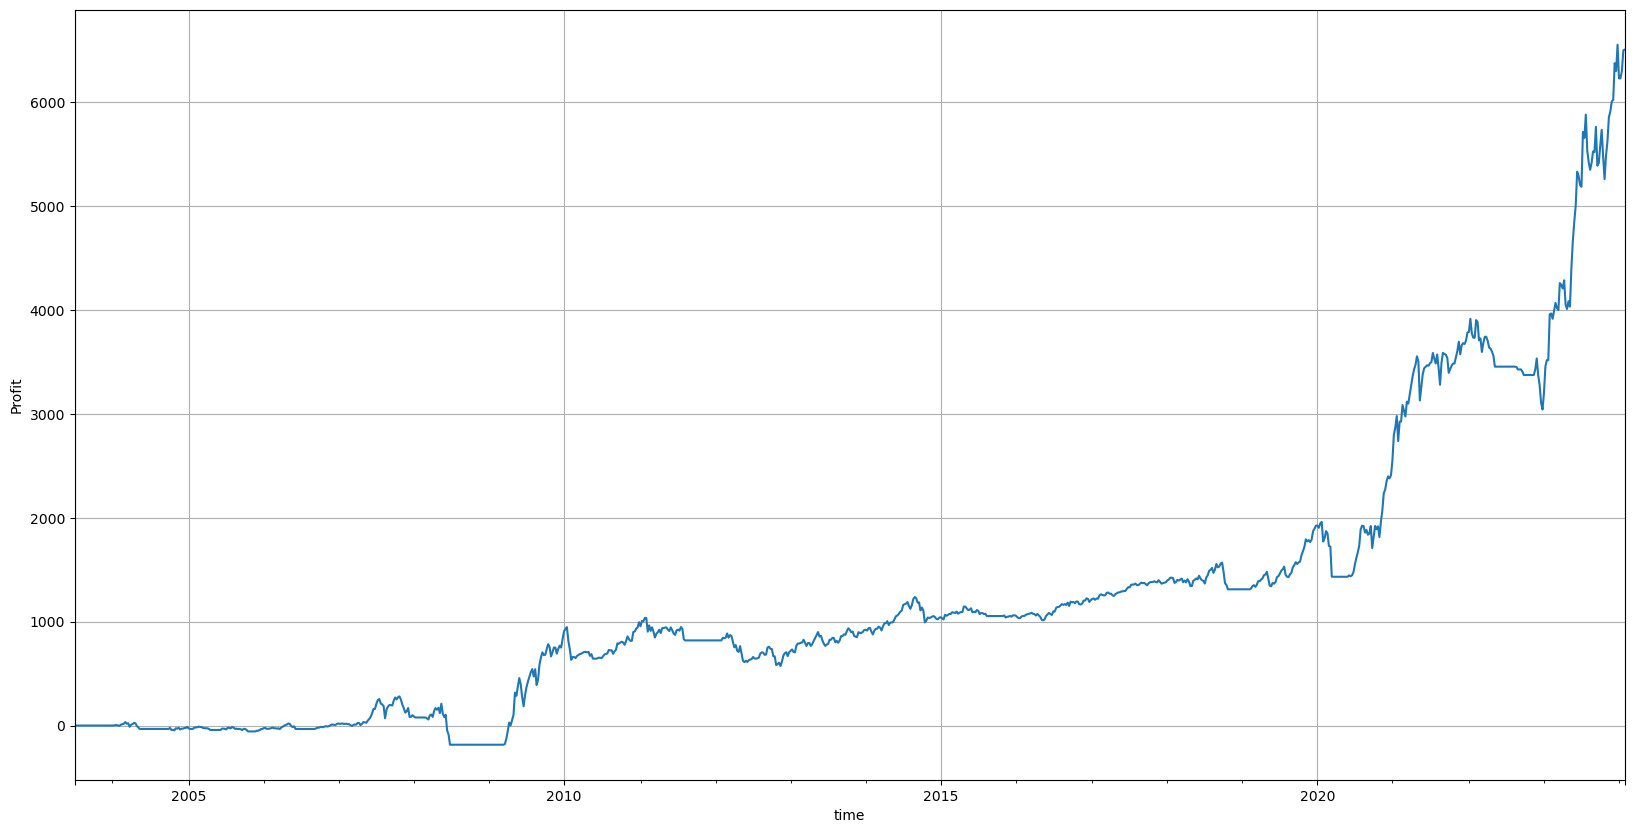

In [15]:
import matplotlib.pyplot as plt
ETF損益圖 = (trr).replace(np.inf,0).sort_index().sum(axis = 1).cumsum().plot(figsize=(20,10),grid = True)

plt.xlabel("time")
plt.ylabel("Profit")
plt.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF.png')

# 整理ETF多單買賣訊01值

20.48
0.0
144.0


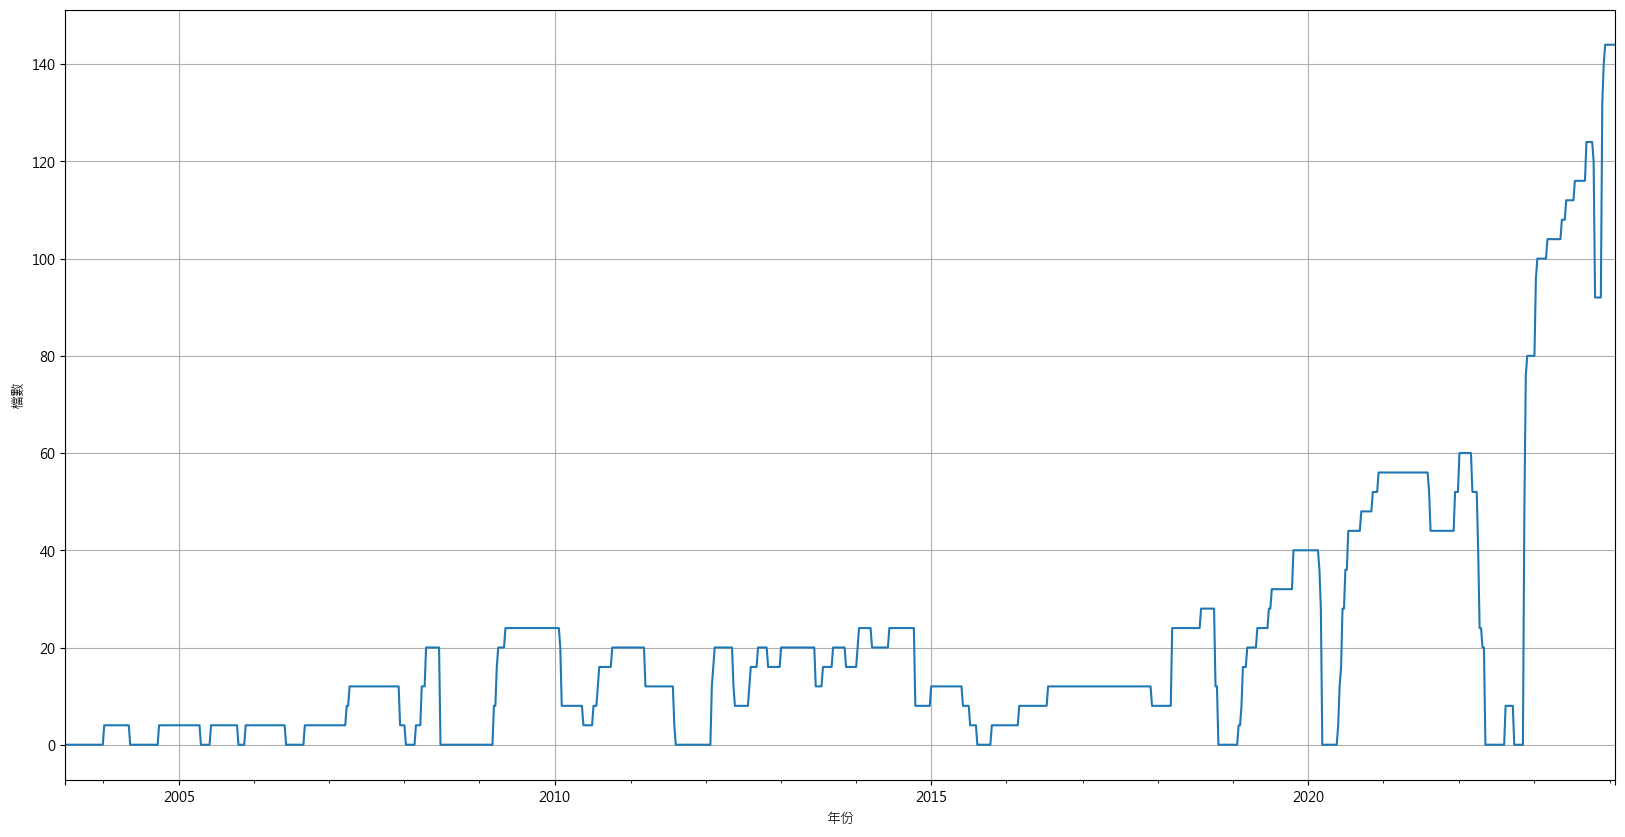

In [16]:
pz1 = pz.sort_index()
f = lambda x :float(x)
pz2 = pz1.applymap(f)
pz3 = pz2.sum(axis=1)
pz4 = pz3.groupby(pd.Grouper(freq='1W')).tail(1)
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
print(pz4.mean())
print(pz4.min())
print(pz4.max())
pz4.plot(figsize=(20, 10),grid = True)
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF部位變化.png')

# 日期設定

In [17]:
當週日期 = trr.index[-1]
前週日期 = trr.index[-2]

# ETF部位概況整理

In [18]:
ETF持有部位 = pz2.loc[當週日期][(pz2.loc[當週日期]==4)]
ETF買進 = pz2.loc[當週日期][(pz2.loc[當週日期]==4) & (pz2.loc[前週日期]==0)]
ETF賣出 = pz2.loc[當週日期][(pz2.loc[當週日期]==0) & (pz2.loc[前週日期]==4)]
print("ETF買進標的")
print(ETF買進)
print("ETF買進檔數" , len(ETF買進))
print("ETF持有部位數目" , len(ETF持有部位))
print("ETF賣出部位")
print(ETF賣出)
print("ETF賣出檔數" , len(ETF賣出))

ETF買進標的
Series([], Name: 2024-02-02 00:00:00, dtype: float64)
ETF買進檔數 0
ETF持有部位數目 36
ETF賣出部位
Series([], Name: 2024-02-02 00:00:00, dtype: float64)
ETF賣出檔數 0


In [19]:
pz2

,0050,0051,0052,0053,0055,0056,0057,006201,006203,006204,...,00922,00923,00927,00928,00929,00930,00932,00934,00935,00936
key_0,,,,,,,,,,,,,,,,,,,,,
2003-07-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-18,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-25,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05,4.0,4.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0
2024-01-12,4.0,4.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0
2024-01-19,4.0,4.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0


# ETF買賣總表

In [20]:
import datetime
每週ETF買賣DF = pd.DataFrame()

每週ETF買賣DF = pd.concat([每週ETF買賣DF,pd.DataFrame(ETF買進.index,columns = ['ETF買進'])],axis=1)
每週ETF買賣DF = pd.concat([每週ETF買賣DF,pd.DataFrame(ETF賣出.index,columns = ['ETF賣出'])],axis=1)

In [21]:
每週ETF買賣DF.to_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\每週ETF買賣\ETF買賣總表'+datetime.datetime.today().strftime('%Y-%m-%d')+'.xlsx')

# ETF部位比對表

In [22]:
from collections import defaultdict

def zero():
    return 0

dict = defaultdict(zero)


if len(ETF持有部位) !=0:
    for i in ETF持有部位.index:
        dict[i] += ETF持有部位.loc[i]*1

In [23]:
import datetime
ETF部位比對表 = pd.DataFrame.from_dict(dict,orient='index').sort_index().rename(columns = {0:'部位'})
ETF部位比對表.to_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF權重部位比對表\ETF部位比對表'+datetime.datetime.today().strftime('%Y-%m-%d')+'.xlsx')
if datetime.datetime.now().weekday() == 0:
    ETF部位比對表.to_excel(r'\\bond\der\期貨自營\理論權重\ETF部位比對表.xlsx')
ETF部位比對表.to_excel(r'\\bond\der\期貨自營\理論權重\ETF部位比對表.xlsx')

# ETF歷年損益

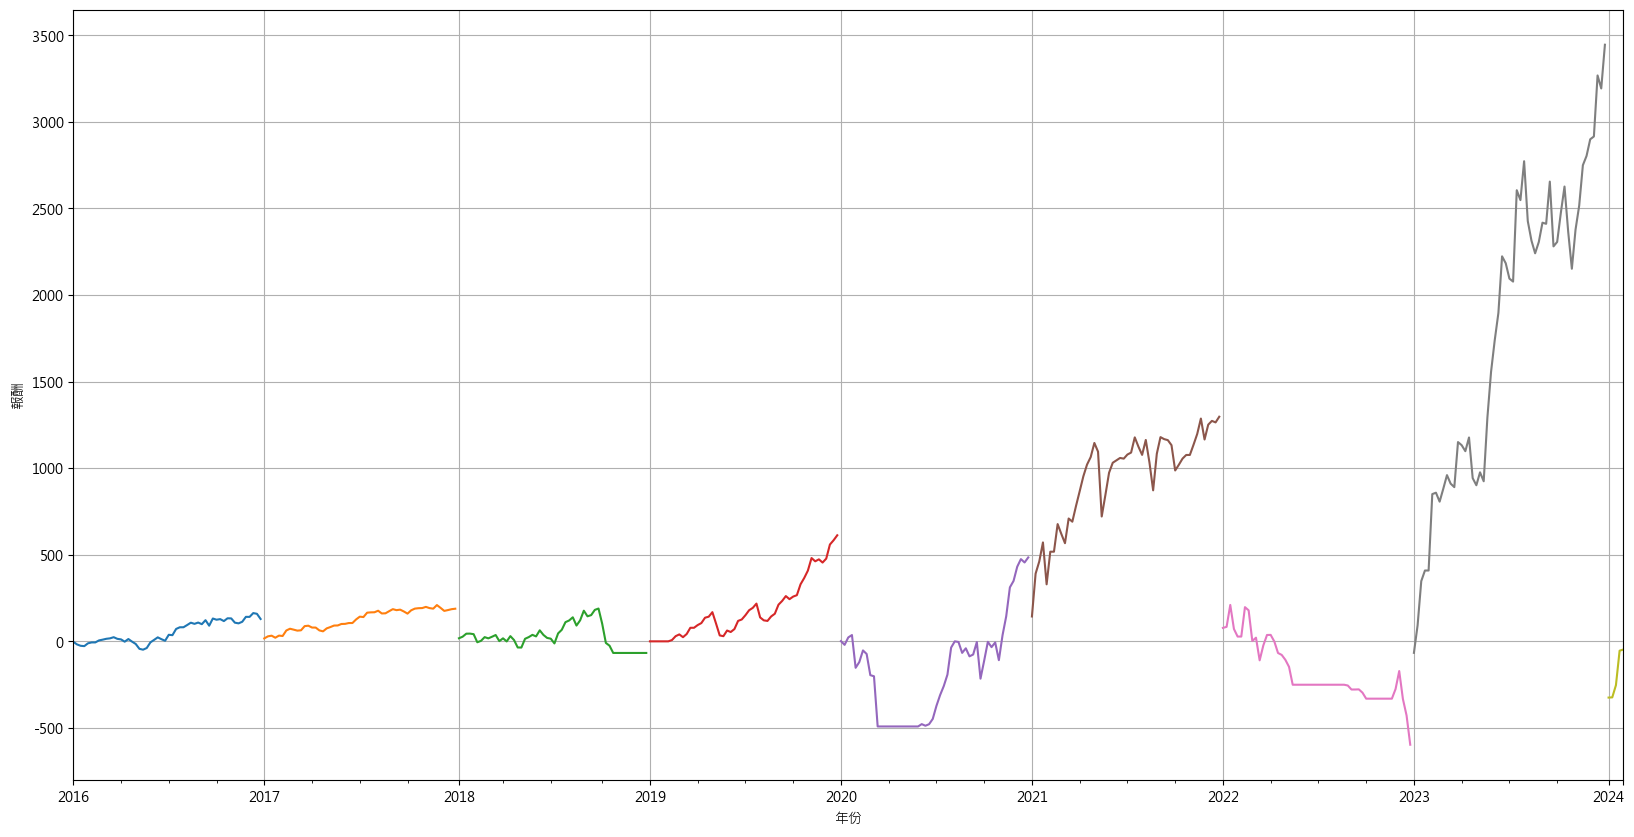

In [24]:
yl = ['2016','2017','2018','2019','2020','2021','2022','2023','2024']
for h in yl :
    trrt = (trr).groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = (trrt).plot(figsize=(20, 10),grid = True)
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF歷年損益.png')

# ETF持有部位

In [25]:
print('ETF持有部位')
print(list(ETF持有部位.index))

ETF持有部位
['0050', '0051', '0052', '0056', '006208', '00690', '00692', '00701', '00713', '00728', '00730', '00731', '00733', '00850', '00878', '00881', '00888', '00891', '00892', '00894', '00896', '00900', '00901', '00905', '00907', '00912', '00915', '00918', '00919', '00921', '00922', '00923', '00927', '00928', '00929', '00930']


# ETF彙總股票關鍵點模型

In [26]:
ETF單週損益 = (trr).replace(np.inf,0).sort_index().sum(axis = 1)
ETF單週損益 = pd.DataFrame(ETF單週損益).reset_index().rename(columns = {'key_0':'日期',0:'long損益'})
ETF單週損益.to_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF單週損益.xlsx')
ETF放空單週損益 = pd.read_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF放空單週損益.xlsx',index_col = 0)
主關鍵點損益 = pd.read_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\分年資料.xlsx')
ETF放空部位 = pd.read_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF空單部位變化.xlsx',index_col = 0)
ETF總部位 = pz4*1000000
ETF單週損益 = ETF單週損益.merge(ETF放空單週損益.reset_index().rename(columns = {'key_0':'日期',0:'short損益'}),on = '日期')
ETF單週損益 = ETF單週損益.merge(ETF總部位.reset_index().rename(columns = {'key_0':'日期',0:'ETF總部位'}),on = '日期')
ETF單週損益 = ETF單週損益.merge(ETF放空部位.reset_index().rename(columns = {'key_0':'日期',0:'放空部位'}),on = '日期')
ETF單週損益 = ETF單週損益.merge(主關鍵點損益.reset_index().rename(columns = {'key_0':'日期',0:'主關鍵點損益'}),on = '日期')

ETF單週損益['ETF_long_short_損益'] = ETF單週損益['long損益'] + ETF單週損益['short損益']*0.5
ETF單週損益['淨部位變化'] = ETF單週損益['ETF總部位'] + (ETF單週損益['放空部位']*1300000)
ETF單週損益['關鍵點+ETF損益'] = ETF單週損益['ETF_long_short_損益'] + ETF單週損益['主關鍵點損益']
pd.DataFrame(ETF單週損益)
ETF單週損益 = ETF單週損益.set_index('日期')

# ETF分項損益與部位

In [27]:
ETF單週損益

,long損益,short損益,ETF總部位,放空部位,index,主關鍵點損益,ETF_long_short_損益,淨部位變化,關鍵點+ETF損益
日期,,,,,,,,,
2003-07-04,0.000000,0.000000,0.0,-1,78,199.961804,0.000000,-1300000.0,199.961804
2003-07-11,0.000000,-2.269044,0.0,-1,79,221.521788,-1.134522,-1300000.0,220.387266
2003-07-18,0.000000,-6.022187,0.0,0,80,134.109485,-3.011094,0.0,131.098391
2003-07-25,0.000000,0.000000,0.0,-1,81,156.522408,0.000000,-1300000.0,156.522408
2003-08-01,0.000000,-2.787947,0.0,0,82,-12.260330,-1.393974,0.0,-13.654304
...,...,...,...,...,...,...,...,...,...
2024-01-05,-324.800137,21.769245,144000000.0,-32,1148,-116.652078,-313.915515,102400000.0,-430.567593
2024-01-12,1.241912,6.809446,144000000.0,-39,1149,-248.257410,4.646635,93300000.0,-243.610775
2024-01-19,70.276897,36.181584,144000000.0,-39,1150,41.627443,88.367689,93300000.0,129.995132


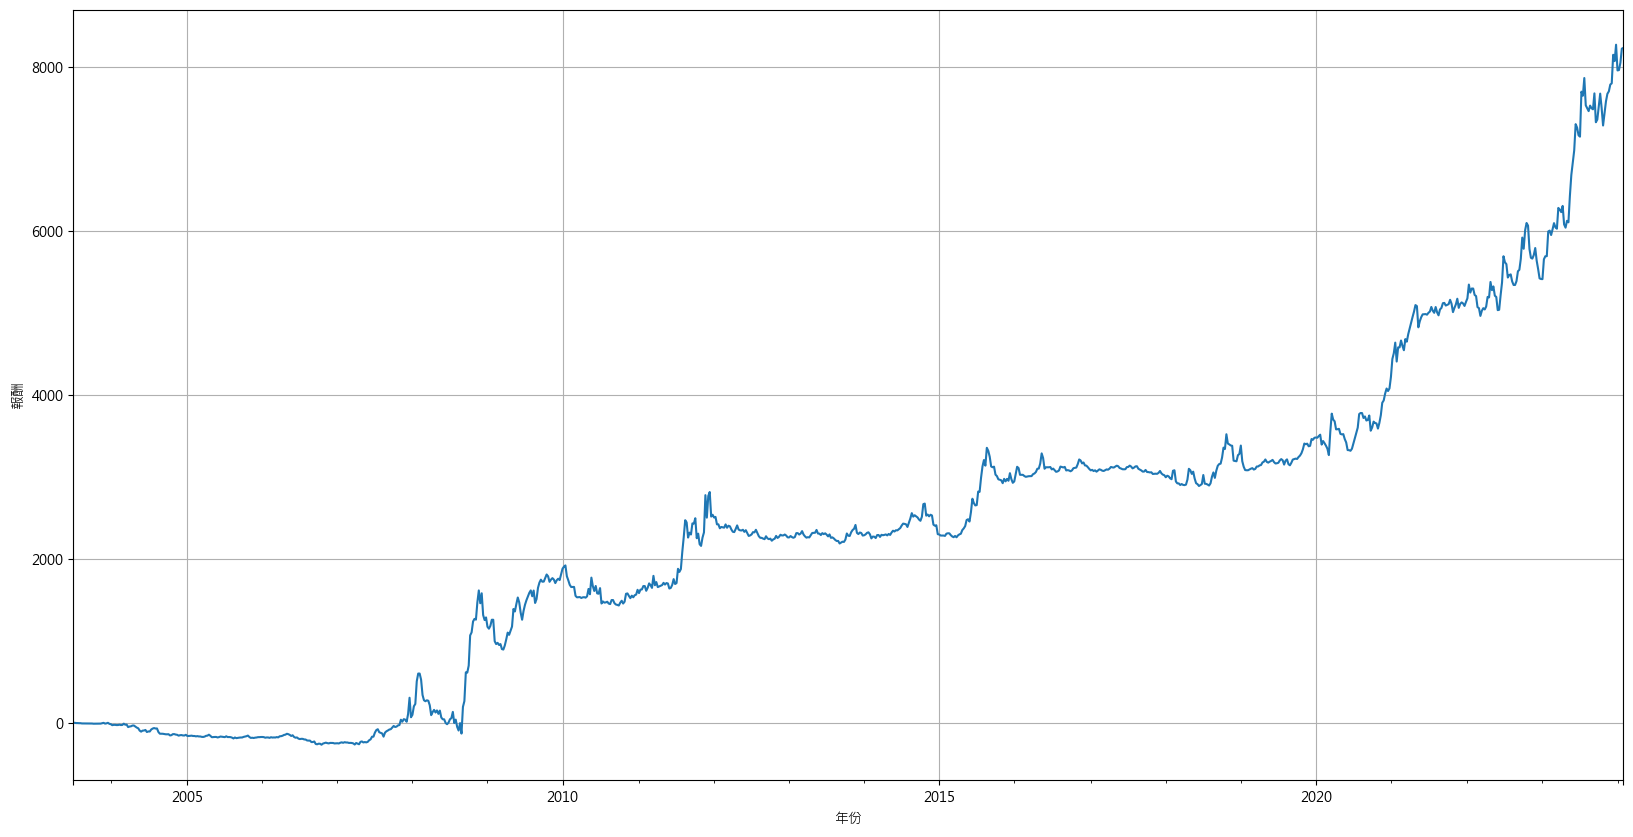

In [28]:
ETF單週損益['ETF_long_short_損益'].cumsum().plot(figsize=(20, 10),grid = True)

plt.xlabel("年份")
plt.ylabel("報酬")
plt.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\ETFLS圖.png')

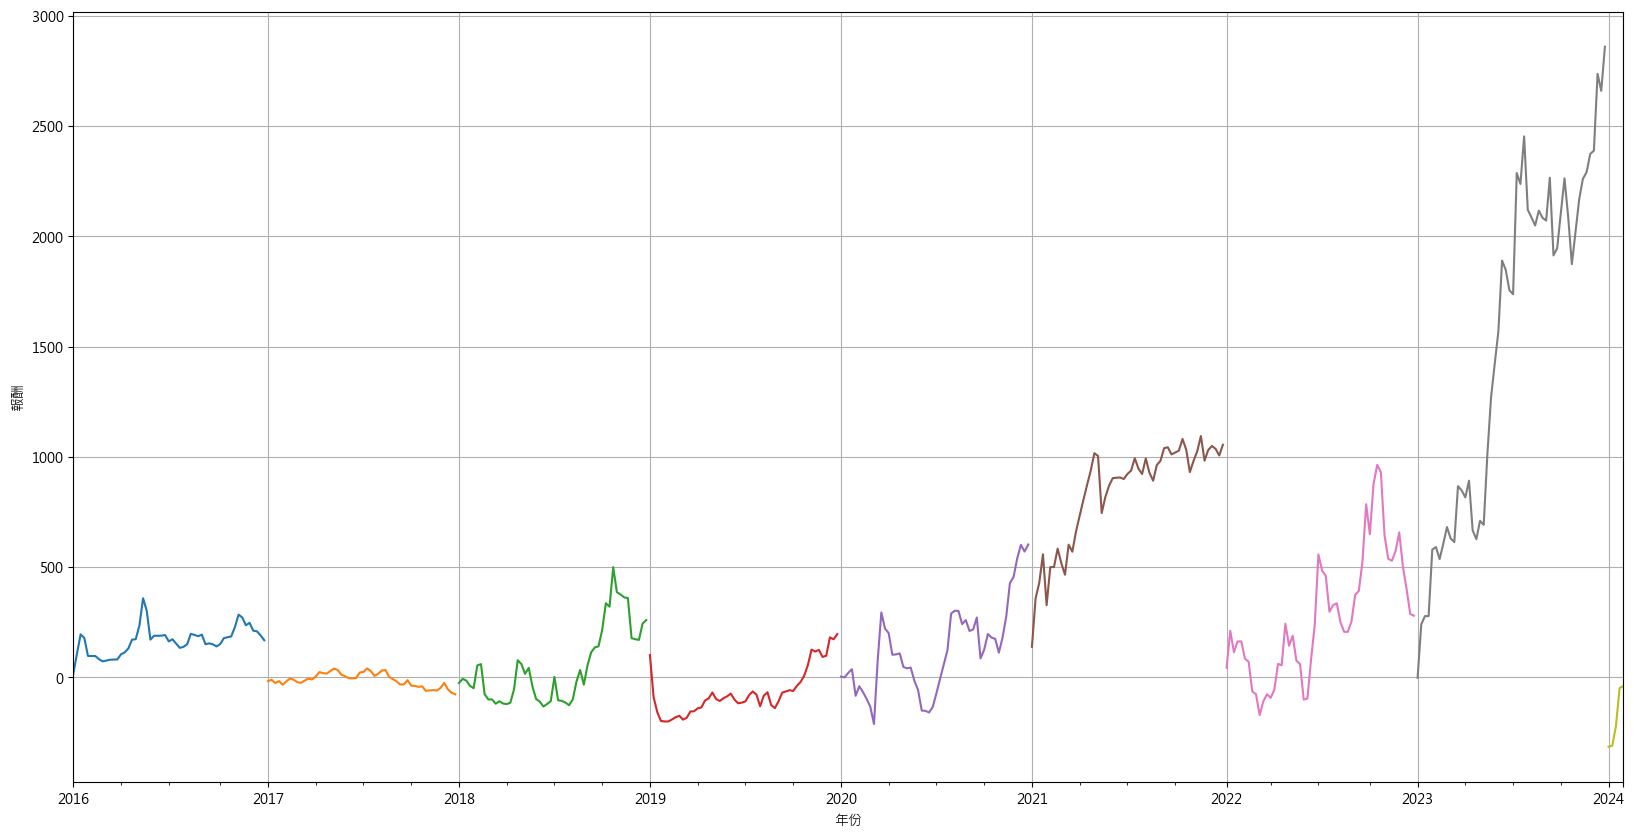

In [29]:
LS = ['2016','2017','2018','2019','2020','2021','2022','2023','2024']
for h in LS :
    trrtLS = (ETF單週損益['ETF_long_short_損益'])[str(h)].cumsum()
    trrtfigLS = (trrtLS).plot(figsize=(20, 10),grid = True)
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\ETFLS歷年損益.png')

# ETF加計空單損益變化

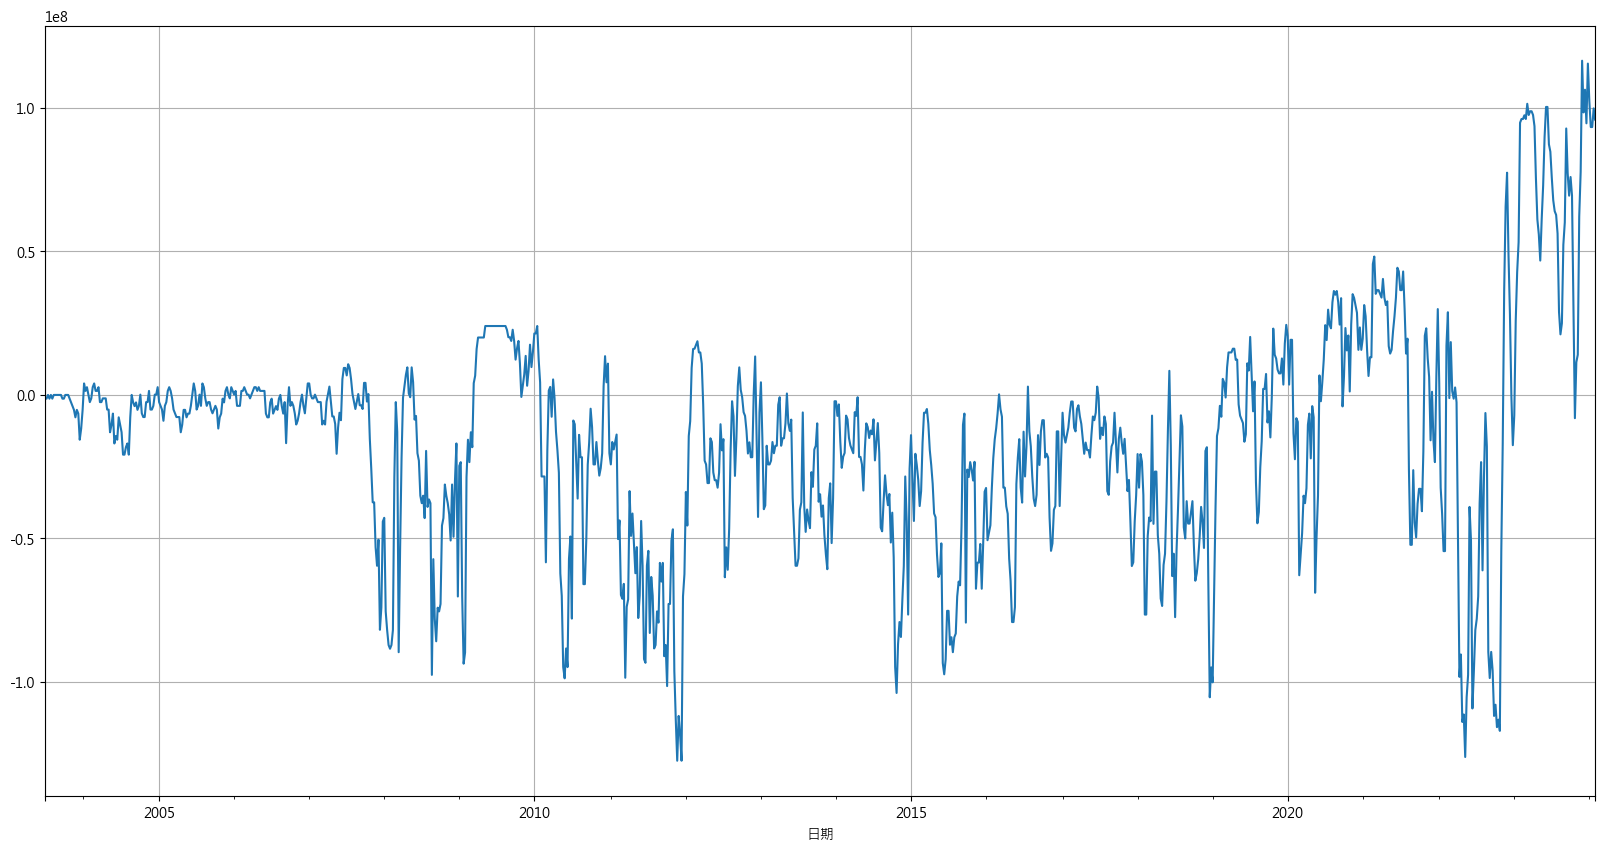

In [30]:
ETF單週損益['淨部位變化'].plot(figsize = (20,10),grid = True)
plt.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF淨部位變化.png')
ETF單週損益['淨部位變化'].to_excel(r'C:\Users\larryx30\larryx30\每週買賣報表\總策略淨部位\總淨部位變化'+datetime.datetime.today().strftime('%Y-%m-%d')+'.xlsx')

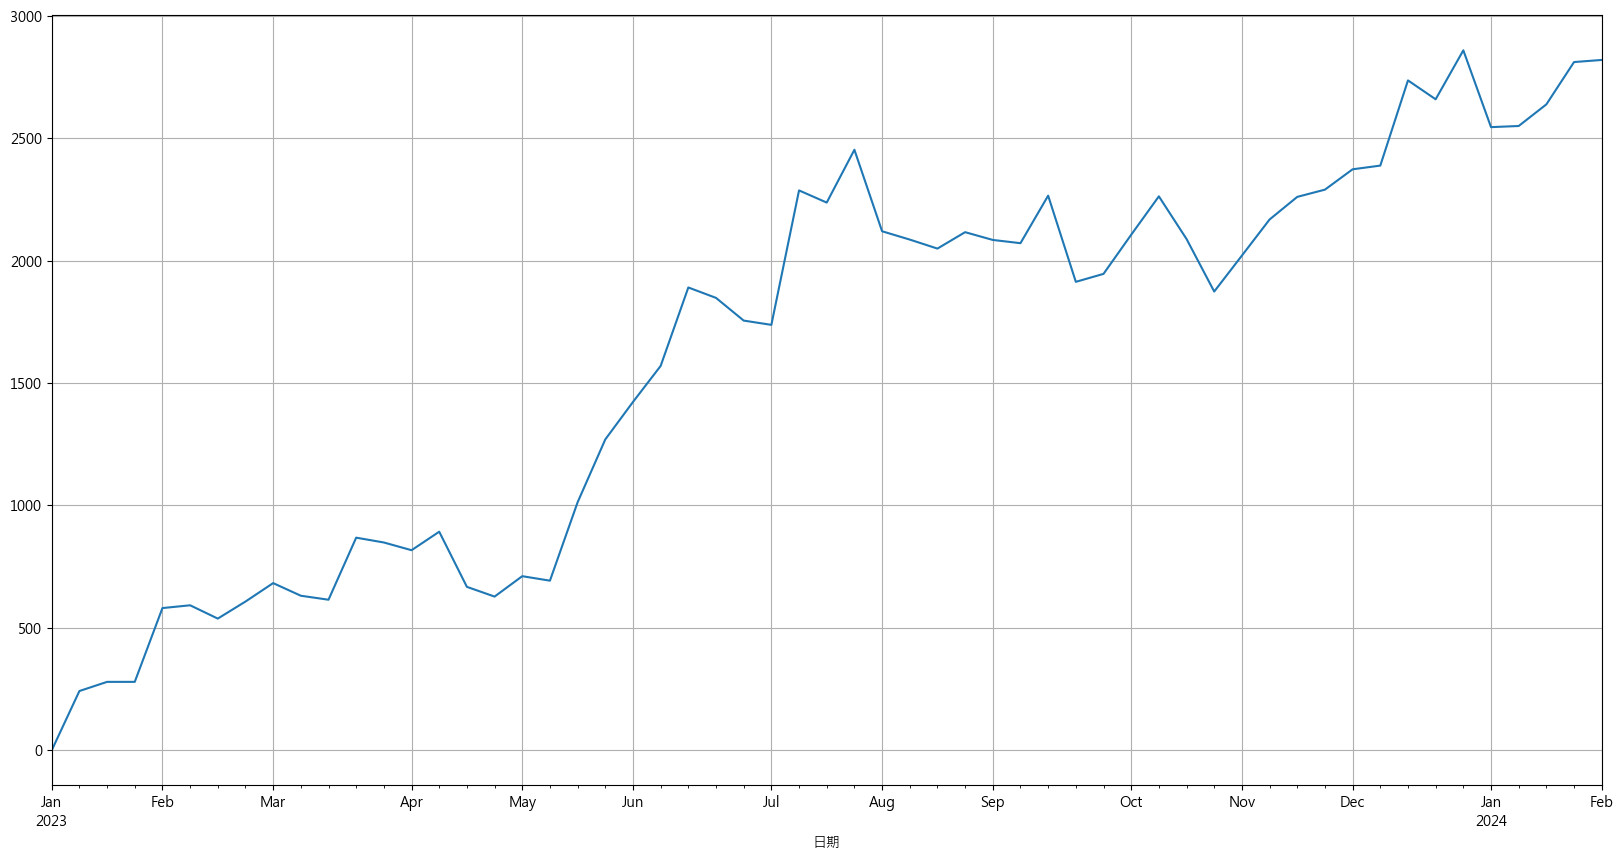

In [31]:
ETF單週損益['ETF_long_short_損益']['2023':].cumsum().plot(figsize = (20,10),grid = True)
plt.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\ETF最終損益.png')

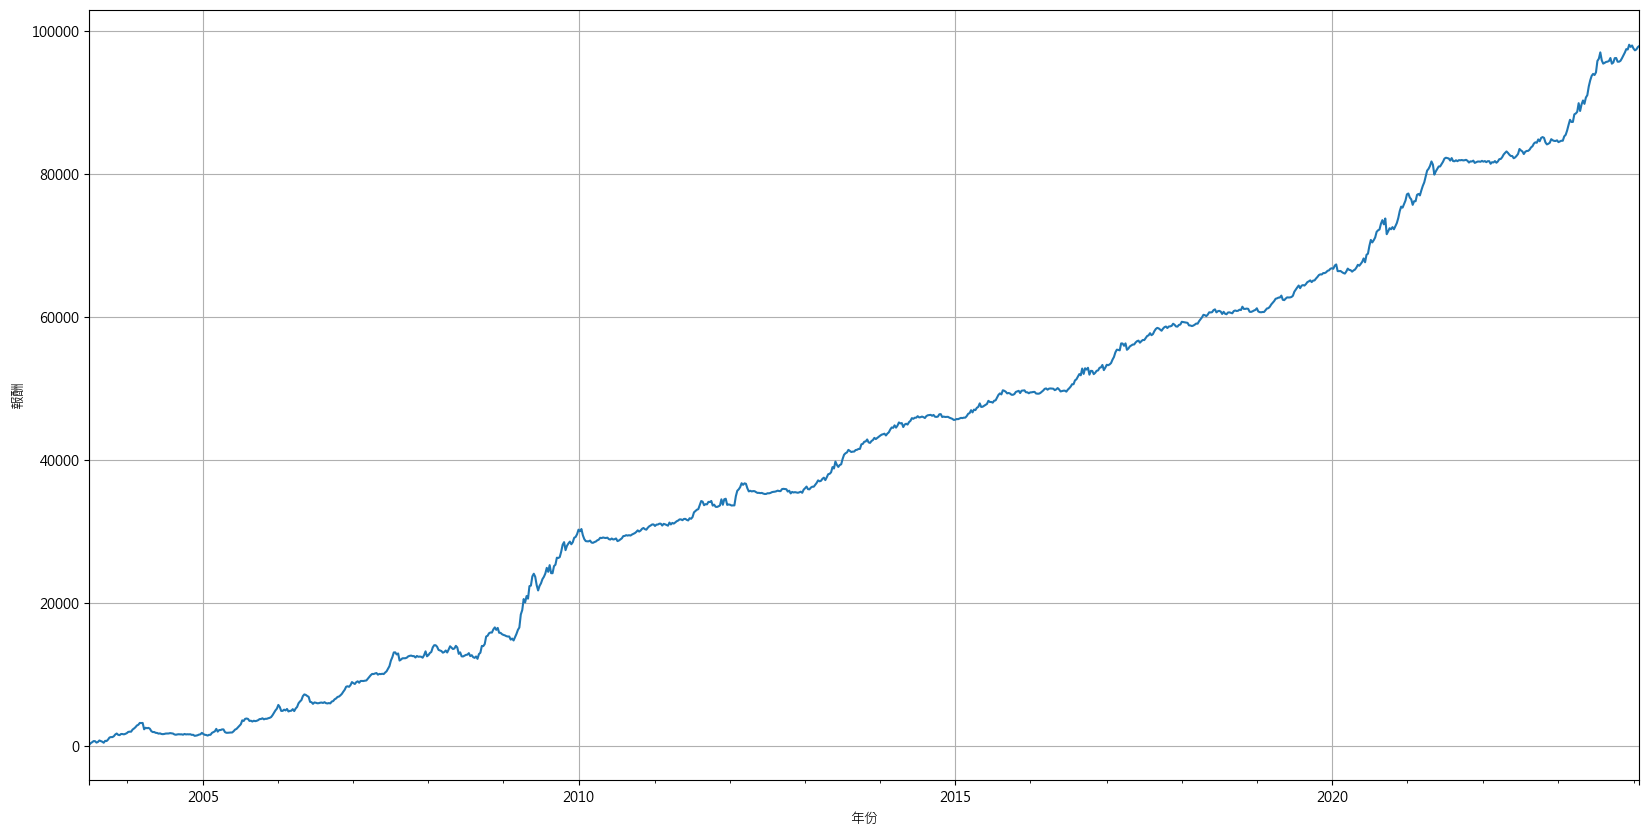

In [32]:
ETF單週損益['關鍵點+ETF損益'].cumsum().plot(figsize=(20, 10),grid = True)

plt.xlabel("年份")
plt.ylabel("報酬")
plt.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\關鍵點+ETF圖.png')

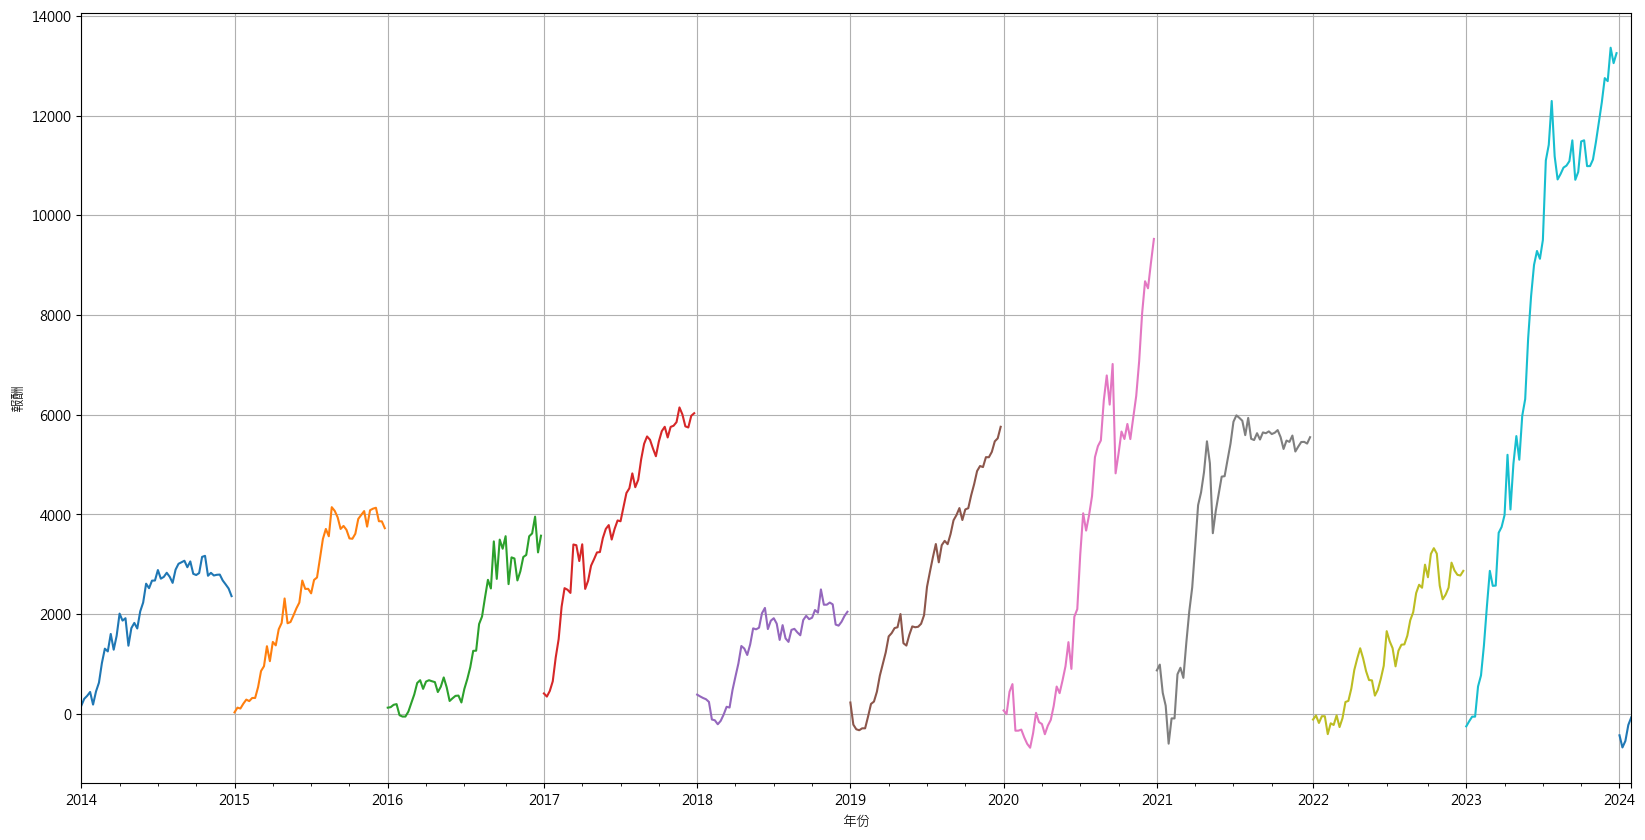

In [33]:
LS = ['2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']
for h in LS :
    trrtTTS = (ETF單週損益['關鍵點+ETF損益'])[str(h)].cumsum()
    trrtfigTTS = (trrtTTS).plot(figsize=(20, 10),grid = True)
trrtfigTTS = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfigTTS.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\關鍵點+ETF歷年損益.png')

In [34]:
# responseBETF = pd.read_excel(r'C:\Users\larryx30\Desktop\\債券型ETF代碼.xlsx')
# responseBETF['股票代號'] = responseBETF['股票代號'].astype(str)
# responseBETF.index = responseBETF.index+1
# BETF = responseBETF['股票代號']

In [35]:
ETF單週損益['關鍵點+ETF損益']

日期
2003-07-04    199.961804
2003-07-11    220.387266
2003-07-18    131.098391
2003-07-25    156.522408
2003-08-01    -13.654304
                 ...    
2024-01-05   -430.567593
2024-01-12   -243.610775
2024-01-19    129.995132
2024-01-26    321.776701
2024-02-02    152.019858
Name: 關鍵點+ETF損益, Length: 1075, dtype: float64

In [36]:
# import talib
# ERROR = []
# Btrr = pd.DataFrame()
# Bpz = pd.DataFrame()

# for x in tqdm(BETF):
    
#     ETFDDW[str(x)]['MAX52'] = ETFDDW[str(x)]["收盤價"].rolling(2).max()
#     ETFDDW[str(x)]["MAX52S"] = ETFDDW[str(x)]["MAX52"].shift(1)
#     ETFDDW[str(x)]["20MA"] = talib.MA(ETFDDW[str(x)]["收盤價"].dropna(), timeperiod=20, matype=0)
#     ETFDDW[str(x)]["20MAS"] = ETFDDW[str(x)]["20MA"].shift(1)
#     ETFDDW[str(x)]["5MA"] = talib.MA(ETFDDW[str(x)]["收盤價"].dropna(), timeperiod=5, matype=0)
#     ETFDDW[str(x)]["5MAS"] = ETFDDW[str(x)]["5MA"].shift(1)
    
#     ETFDDW[str(x)]["DR"] = ((ETFDDW[str(x)]["收盤價"] - ETFDDW[str(x)]["收盤價"].shift(1))/ETFDDW[str(x)]["收盤價"].shift(1))*100
    
    
#     BKPBS = 0
#     BKPBUY =[]
#     for z in range(len(ETFDDW[str(x)])):

#         if ETFDDW[str(x)]["收盤價"].iloc[z]  > ETFDDW[str(x)]["MAX52S"].iloc[z] and ETFDDW[str(x)]['成交金額(千)'].iloc[z] > 50000 \
#         and ETFDDW[str(x)]["最低價"].iloc[z] > ETFDDW[str(x)]["20MAS"].iloc[z] :
        
#             BKPBS = 1

#         elif ETFDDW[str(x)]["收盤價"].iloc[z] < ETFDDW[str(x)]["最低價"].rolling(1).min().shift(1).iloc[z]  and \
#          (( ETFDDW[str(x)]['收盤價'].iloc[z] < ETFDDW[str(x)]['收盤價'].rolling(5).min().shift(1).iloc[z]) ) :
         
#             BKPBS = 0
            
#         BKPBUY.append(BKPBS)
#     ETFDDW[str(x)]["BKPBUY"] = BKPBUY
#     ETFDDW[str(x)]["BKPBUYS"] = ETFDDW[str(x)]["BKPBUY"].shift(1)
#     Bpzb = ETFDDW[str(x)]["BKPBUYS"]  
#     Bpzb.name = str(x)
#     Bpzbs = ETFDDW[str(x)]["BKPBUY"]
#     Bpzbs.name = str(x)
#     ETFDDW[str(x)]["BKPRR"] = ETFDDW[str(x)]["DR"] * ETFDDW[str(x)]["BKPBUYS"].dropna().astype(int)
#     BPT = ETFDDW[str(x)]["BKPRR"]
#     BPT.name = str(x)
#     if len(Btrr) == 0:
#         Btrr = BPT
#     else:
#         Btrr = pd.merge(Btrr,BPT,left_on = Btrr.index,right_on = BPT.index,how = 'outer')
#         Btrr.set_index('key_0',inplace = True)
#     if len(Bpz) == 0:
#         Bpz = Bpzbs
#     else:
#         Bpz = pd.merge(Bpz,Bpzbs,left_on = Bpz.index,right_on = Bpzbs.index,how = 'outer')
#         Bpz.set_index('key_0',inplace = True)

# Btrrb =(Btrr*10).replace(np.inf,0).sort_index().sum(axis = 1).cumsum().plot(figsize=(20, 10),grid = True)
